# Exercise 1 for Monte Calro simulation of the 2d Ising model
2019, May, Tsuyoshi Okubo  
2021, April, Tsuyoshi Okubo  
2022, May, Tsuyoshi Okubo (changed Ising_lib.py and output of MC)  
2023, May, Tsuyoshi Okubo (Added improved estimator for Binder ratio) 


This code simulate 2d Ising model on the square lattice, whose Hamiltonian is given by
$$ \mathcal{H} = -J \sum_{\langle i,j\rangle} S_i S_j - h \sum_i S_i ,$$
where $S_i = \pm 1$.

You can select three simulation algorithms explained in the lecture:
* metropolis
* heatbath
* cluster (Swendsen-Wang)

The main outputs are:
* Energy: $\langle E\rangle = \langle \mathcal{H}\rangle/N$.
* Squared magnetization: $\langle M^2\rangle = \langle (\sum_i S_i)^2\rangle/N^2$.
* Specific heat: $N(\langle E^2\rangle - \langle E\rangle^2)/T$
* Magnetic susceptibility: $N(\langle M^2\rangle)/T$ (It is correct only for $h=0$)
* Binder ratio: $\langle M^4\rangle/\langle M^2\rangle^2$


The code will make graphs of 
* Dynamics of physical quantities
* Auto-corelations of them

By varying, system size $L$, the temperature $T$, the external magnetic field $h$, and the algorithm, let's see how the correlation times or erros in the expectations values change.

#### Parameters for MC simulations
* themalizatoin: MC steps for thermalization, which is not used for calculating expectation values.
* observation: MC steps for observation, which is used for calculating expectation values.
* random_seed: Seed for random numbser generator. For the same random_seed, you always obtain the same result.

#### Parameters for auto correlations
* correlation_time: The longest time (MC steps) for plotting the auto-correlation fuctions.
    * In order to obtain more accurate auto correlation fuctions, you may need to increase "observation".

#### Important notice
* This code works on python3 with numpy and numba modules.

In [1]:
import numpy as np
from Ising_lib import *
#%matplotlib notebook
%matplotlib inline
from matplotlib import pyplot


In [2]:
#Parameters for calculation
Tc = 2.0/np.log(1.0+np.sqrt(2.0)) ## The critical temperature of the Ising model

L=16
T=Tc ## T means T/J
h = 0
N=L*L

#algorithm="metropolis"
#algorithm="heatbath"
algorithm = "cluster"

random_seed = 11
thermalization = 10000
observation = 50000

correlation_time = 500


In [3]:
%%time
## Initialization and run simulation
mag, mag2, mag2_imp, mag4, mag4_imp, mag_abs, ene, ene2 = MC(L,T,h,thermalization,observation,random_seed,algorithm)

CPU times: user 2.5 s, sys: 25 ms, total: 2.53 s
Wall time: 2.55 s


In [4]:
## Output with error estimated by Jackknife method
def variance(e,e2):
    return e2 -e**2
def binder(m2,m4):
    return m4 / m2 **2

E, E_err = Jackknife(ene,bin_size=max(100,observation//100))
E2,E2_err = Jackknife(ene2,bin_size=max(100,observation//100))
M,M_err = Jackknife(mag,bin_size=max(100,observation//100))
M2,M2_err = Jackknife(mag2,bin_size=max(100,observation//100))
M4,M4_err = Jackknife(mag4,bin_size=max(100,observation//100))
C, C_err = Jackknife(ene,bin_size=max(100,observation//100),func=variance, data2=ene2)
C *= N/T**2
C_err *= N/T**2
b, b_err = Jackknife(mag2,bin_size=max(100,observation//100),func=binder, data2=mag4)


print ("[Outputs with errors estimated by Jackknife method]")
print ("T = " + repr(T))
print ("Energy = " + repr(E) + " +- " +repr(E_err))
print ("Energy^2 = " + repr(E2) + " +- " +repr(E2_err))
print ("Magnetization = " + repr(M) + " +- " +repr(M_err))
print ("Magnetization^2 = " + repr(M2) + " +- " +repr(M2_err))
print ("Magnetization^4 = " + repr(M4) + " +- " +repr(M4_err))
print ("Specific heat = " + repr(C) + " +- " +repr(C_err))
print ("Susceptibility = " + repr(M2/T * N) + " +- " +repr(M2_err/T * N))
print ("Binder ratio = " + repr(b) + " +- " +repr(b_err))

if algorithm == "cluster":
    M2_imp, M2_imp_err = Jackknife(mag2_imp,bin_size=max(100,observation//100))
    print ("Magnetization^2: improved estimator = " + repr(M2_imp) + " +- " +repr(M2_imp_err))
    print ("Susceptibility: improved estimator  = " + repr(M2_imp/T * N) + " +- " +repr(M2_imp_err/T * N))
    b_imp, b_imp_err = Jackknife(mag2_imp,bin_size=max(100,observation//100),func=binder, data2=mag4_imp)
    print ("Bindar ratio: improved estimator = " + repr(b_imp) + " +- " +repr(b_imp_err))


[Outputs with errors estimated by Jackknife method]
T = 4.538370628426044
Energy = -0.4793325000000002 +- 0.0006256881452796307
Energy^2 = 0.23979830078125 +- 0.0006180089653974928
Magnetization = 6.374999999999996e-05 +- 0.0005051961143477059
Magnetization^2 = 0.012906032714843745 +- 8.704305049835012e-05
Magnetization^4 = 0.000492394797950983 +- 7.037169449928891e-06
Specific heat = 0.12477150489262513 +- 0.0008120981223616386
Susceptibility = 0.7280023262766977 +- 0.00490991652114266
Binder ratio = 2.9561587879232882 +- 0.017188822603996276
Magnetization^2: improved estimator = 0.013016742553710936 +- 1.3792393537689504e-05
Susceptibility: improved estimator  = 0.7342472368559446 +- 0.0007780000874175081
Bindar ratio: improved estimator = 2.9477266991941957 +- 0.0007235058830001277


In the following, we will analyze dynamics of the physical quantities:
* Magnetization
* Squared Magnetization
    * In the case of cluster algorithm, we also plot Squared Magnetization obtaind by the improved estimator
* Energy

The dynamics of magnetizations might be interesting. For low temperatures, the sign of magnetization hardly chages in the case of local updates (metropolis and heat bath). On the other hand, in the case of cluster update, the sign frequently changes even at a low temperature.

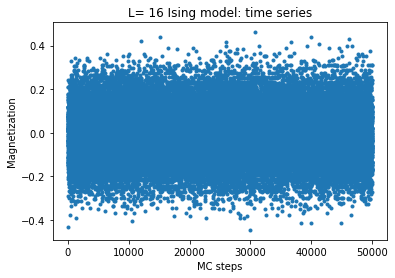

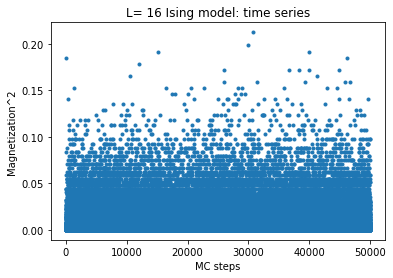

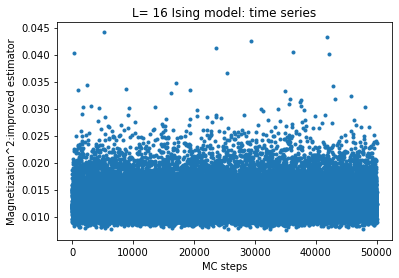

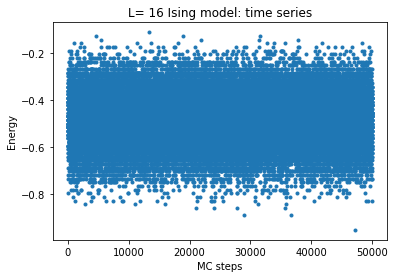

In [5]:
## plot time series

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Magnetization")
pyplot.plot(np.arange(mag.size),mag,".")

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Magnetization^2")
pyplot.plot(np.arange(mag2.size),mag2,".")

if algorithm == "cluster":
    pyplot.figure()
    pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
    pyplot.xlabel("MC steps")
    pyplot.ylabel("Magnetization^2:improved estimator")
    pyplot.plot(np.arange(mag2_imp.size),mag2_imp,".")



pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " time series")
pyplot.xlabel("MC steps")
pyplot.ylabel("Energy")
pyplot.plot(np.arange(ene.size),ene,".")

pyplot.show()

In the following, we will plot autocorrelation functions obtained by the time series of the physical quantities:
* Magnetization
* Squared Magnetization
    * In the case of cluster algorithm, we also plot Squared Magnetization obtaind by the improved estimator
* Energy

(In addition, the integrated auto-correlation times will be caluculated.)

You will see that when L is incresed, the correlation times become longer in the vicinity of the critical temperature. In adittion, the corration-time difference between local updates and cluster update became much lager (longer) when L is increased.
(Is is also interesting to compare the correlation times of metropolis and head bath methods.)

### Important notice
If the correlation time becomes longer, you need to increase "thermalization" and "observation" steps to obtain reliable expectation values. The estimation of the correlaiton time also becomes inacurate when thermalization and observation steps are short. 

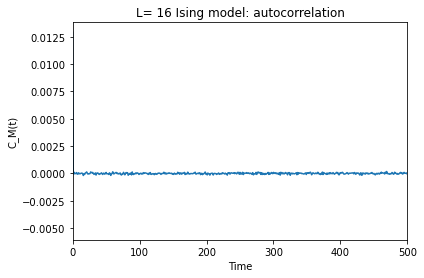

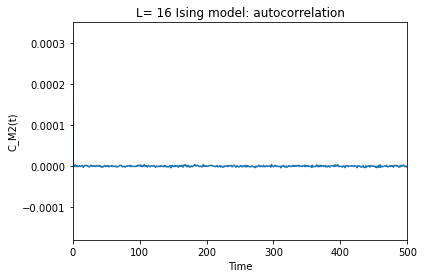

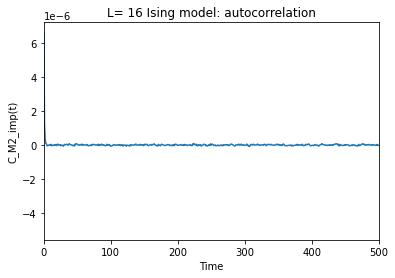

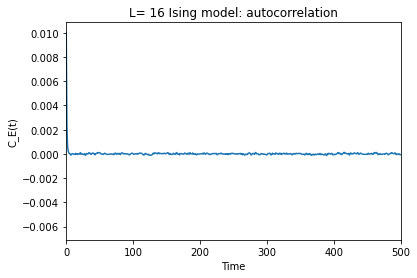

In [6]:
## plot autocorrelation
mag_d = mag - mag.mean()
mag2_d = mag2 - mag2.mean()
ene_d = ene - ene.mean()

cor_mag = np.correlate(mag_d,mag_d,mode="full")
cor_mag = cor_mag[cor_mag.size//2:]/np.arange(mag_d.size,0,-1)
cor_mag2 = np.correlate(mag2_d,mag2_d,mode="full")
cor_mag2 = cor_mag2[cor_mag2.size//2:]/np.arange(mag2_d.size,0,-1)
cor_ene = np.correlate(ene_d,ene_d,mode="full")
cor_ene = cor_ene[cor_ene.size//2:]/np.arange(ene_d.size,0,-1)


pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_M(t)")
pyplot.plot(np.arange(cor_mag.size),cor_mag)
pyplot.xlim([0,correlation_time])

pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_M2(t)")
pyplot.plot(np.arange(cor_mag2.size),cor_mag2)
pyplot.xlim([0,correlation_time])

if algorithm == "cluster":
    mag2_imp_d = mag2_imp - mag2_imp.mean()
    cor_mag2_imp = np.correlate(mag2_imp_d,mag2_imp_d,mode="full")
    cor_mag2_imp = cor_mag2_imp[cor_mag2_imp.size//2:]/np.arange(mag2_imp_d.size,0,-1)

    pyplot.figure()
    pyplot.title("L= " + repr(L)+" Ising model:"+ " autocorrelation")
    pyplot.xlabel("Time")
    pyplot.ylabel("C_M2_imp(t)")
    pyplot.plot(np.arange(cor_mag2_imp.size),cor_mag2_imp)
    pyplot.xlim([0,correlation_time])


pyplot.figure()
pyplot.title("L= " + repr(L)+" Ising model:"+ " autocorrelation")
pyplot.xlabel("Time")
pyplot.ylabel("C_E(t)")
pyplot.plot(np.arange(cor_ene.size),cor_ene)
pyplot.xlim([0,correlation_time])

pyplot.show()

In [7]:
## output integrated correlation time
print("Tau Magnetization = " + repr(np.sum(cor_mag[:correlation_time])/cor_mag[0]))
print("Tau Magnetization^2 = " + repr(np.sum(cor_mag2[:correlation_time])/cor_mag2[0]))
if algorithm == "cluster":
    print("Tau Magnetization^2: improved estimator = " + repr(np.sum(cor_mag2_imp[:correlation_time])/cor_mag2_imp[0]))
print("Tau Energy = " + repr(np.sum(cor_ene[:correlation_time])/cor_ene[0]))

Tau Magnetization = 1.0592519205290059
Tau Magnetization^2 = 1.0625890763855905
Tau Magnetization^2: improved estimator = 1.2274135960746386
Tau Energy = 1.5420760002300544
